In [1]:
!pip install pennylane pennylane-qiskit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 27.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.1/19.1 MB 45.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 53.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 41.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.9/249.9 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 44.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 362.2 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.4/39.4 MB 20.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━

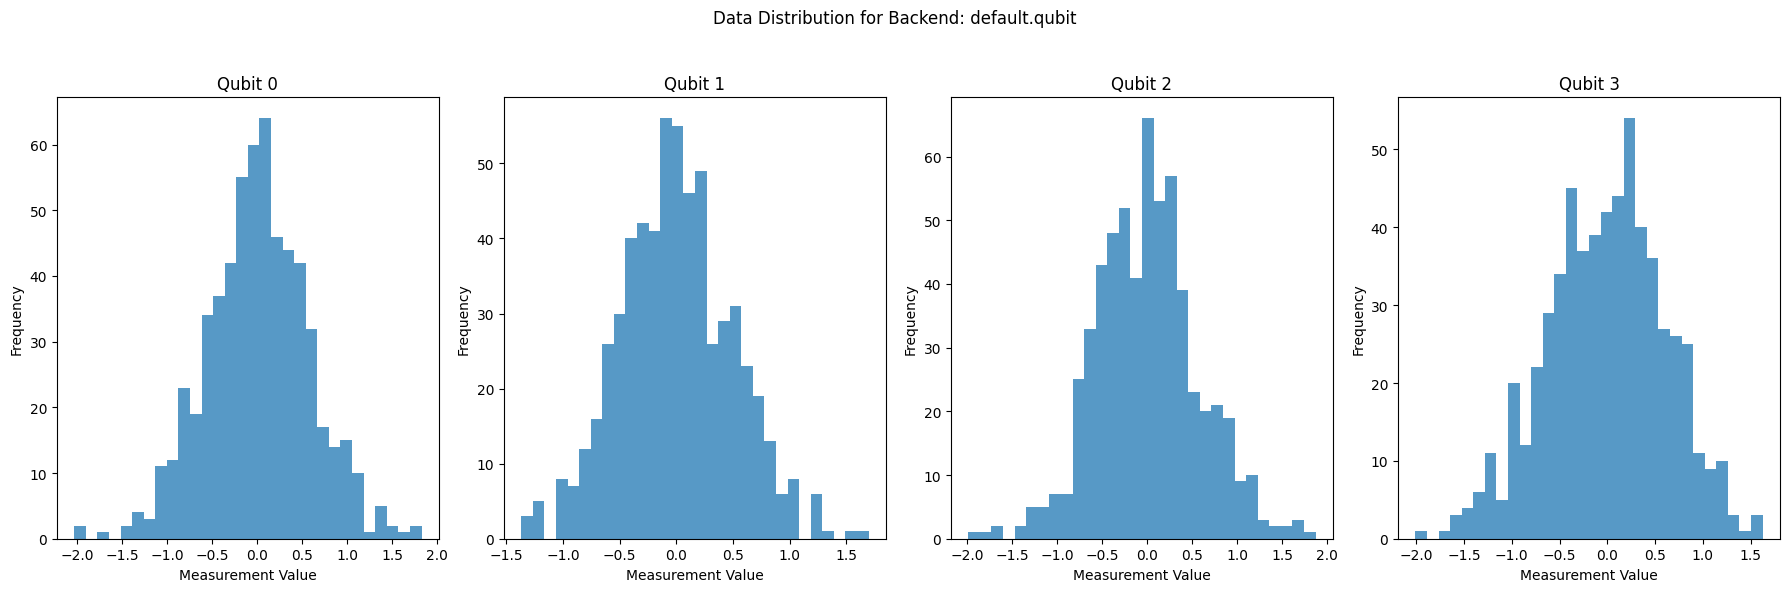

Discriminator Step 0: cost = 0.019391667935070855


Discriminator Step 5: cost = 0.001423820464208081


Discriminator Step 10: cost = -0.004823187116292926


Discriminator Step 15: cost = -0.03156061146305156


Discriminator Step 20: cost = -0.16788738631400868


Discriminator Step 25: cost = -0.41930318728313176


Discriminator Step 30: cost = -0.4928261671787476


Discriminator Step 35: cost = -0.5009756690333771


Discriminator Step 40: cost = -0.5018892203646644


Discriminator Step 45: cost = -0.5020245614689565


Generator Step 0: cost = -0.576181578287268


Generator Step 5: cost = -0.8844056470967414


Generator Step 10: cost = -0.9791658075790267


Generator Step 15: cost = -0.9956668551752761


Generator Step 20: cost = -0.9989735737677994


Generator Step 25: cost = -0.999744961527761


Generator Step 30: cost = -0.9999350395228522


Generator Step 35: cost = -0.999982661365858


Generator Step 40: cost = -0.9999946578479337


Generator Step 45: cost = -0.9999976862333009


Prob(real classified as real): 0.9999586542003256
Prob(fake classified as real): 0.9999983694672643
Discriminator cost: 3.97152669386891e-05
Real Bloch vector: [tensor(-0.21694187, requires_grad=True), tensor(0.45048443, requires_grad=True), tensor(-0.8660254, requires_grad=True)]
Generator Bloch vector: [<tf.Tensor: shape=(), dtype=float64, numpy=-0.20454576521115947>, <tf.Tensor: shape=(), dtype=float64, numpy=0.45498173843167716>, <tf.Tensor: shape=(), dtype=float64, numpy=-0.8666901353499099>]
Accuracy of the classifier on generated data: 0.33


In [15]:
import numpy as np
import pennylane as qml
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import itertools

# Set the seed for reproducibility
np.random.seed(42)

# Setup Quantum Backends and Parameters
qubits = 4
depth = 2
num_samples = 200
noise_strength = 0.5
backend_names = ['default.qubit', 'qiskit.aer', 'qiskit.ibmq']

# Define Quantum Volume Circuit with Noise
def quantum_volume_circuit_with_noise(qubits, depth, noise_strength=0.5, seed=None):
    dev = qml.device("default.qubit", wires=qubits)

    @qml.qnode(dev)
    def circuit():
        np.random.seed(seed)
        # Apply random rotations
        for wire in range(qubits):
            qml.RX(np.random.uniform(0, 2 * np.pi), wires=wire)
            qml.RY(np.random.uniform(0, 2 * np.pi), wires=wire)
            qml.RZ(np.random.uniform(0, 2 * np.pi), wires=wire)

        # Interleave random two-qubit gates
        for _ in range(depth):
            qml.broadcast(qml.CNOT, wires=range(qubits), pattern='ring')
            qml.broadcast(qml.CY, wires=range(qubits), pattern='ring')
            qml.broadcast(qml.CZ, wires=range(qubits), pattern='ring')

        # Measure Pauli observables
        measurements = [qml.expval(qml.PauliX(wire)) for wire in range(qubits)]
        measurements += [qml.expval(qml.PauliY(wire)) for wire in range(qubits)]
        measurements += [qml.expval(qml.PauliZ(wire)) for wire in range(qubits)]

        return measurements

    return circuit

# Generate Synthetic Data
circuits = []
for backend_name in backend_names:
    dev = qml.device('default.qubit', wires=qubits)
    circuit = quantum_volume_circuit_with_noise(qubits, depth, noise_strength)
    circuits.append((dev, circuit))

data = {backend_name: [] for backend_name in backend_names}
for backend, circuit in circuits:
    for _ in range(num_samples):
        result = np.array(circuit())
        noisy_result = result + np.random.normal(scale=noise_strength, size=result.shape)
        data[backend.name].append(noisy_result)

# Visualize Data Distributions
for backend_name in backend_names:
    backend_data = np.array(data[backend_name])
    if len(backend_data) > 0:
        plt.figure(figsize=(18, 6))
        plt.suptitle(f"Data Distribution for Backend: {backend_name}")
        for i, qubit in enumerate(range(qubits)):
            plt.subplot(1, qubits, i + 1)
            plt.hist(backend_data[:, i], bins=30, alpha=0.75)
            plt.xlabel("Measurement Value")
            plt.ylabel("Frequency")
            plt.title(f"Qubit {qubit}")
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()


# Real Data Circuit
def real(angles, **kwargs):
    qml.Hadamard(wires=0)
    qml.Rot(*angles, wires=0)

# Generator Circuit
def generator(w, **kwargs):
    qml.Hadamard(wires=0)
    qml.RX(w[0], wires=0)
    qml.RX(w[1], wires=1)
    qml.RY(w[2], wires=0)
    qml.RY(w[3], wires=1)
    qml.RZ(w[4], wires=0)
    qml.RZ(w[5], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RX(w[6], wires=0)
    qml.RY(w[7], wires=0)
    qml.RZ(w[8], wires=0)

# Discriminator Circuit
def discriminator(w):
    qml.Hadamard(wires=0)
    qml.RX(w[0], wires=0)
    qml.RX(w[1], wires=2)
    qml.RY(w[2], wires=0)
    qml.RY(w[3], wires=2)
    qml.RZ(w[4], wires=0)
    qml.RZ(w[5], wires=2)
    qml.CNOT(wires=[0, 2])
    qml.RX(w[6], wires=2)
    qml.RY(w[7], wires=2)
    qml.RZ(w[8], wires=2)

# QNodes
@qml.qnode(dev)
def real_disc_circuit(phi, theta, omega, disc_weights):
    real([phi, theta, omega])
    discriminator(disc_weights)
    return qml.expval(qml.PauliZ(2))

@qml.qnode(dev)
def gen_disc_circuit(gen_weights, disc_weights):
    generator(gen_weights)
    discriminator(disc_weights)
    return qml.expval(qml.PauliZ(2))

# QGAN Cost Functions
def prob_real_true(disc_weights):
    true_disc_output = real_disc_circuit(phi, theta, omega, disc_weights)
    return (true_disc_output + 1) / 2

def prob_fake_true(gen_weights, disc_weights):
    fake_disc_output = gen_disc_circuit(gen_weights, disc_weights)
    return (fake_disc_output + 1) / 2

def disc_cost(disc_weights):
    return prob_fake_true(gen_weights, disc_weights) - prob_real_true(disc_weights)

def gen_cost(gen_weights):
    return -prob_fake_true(gen_weights, disc_weights)

# Training QGAN
phi = np.pi / 6
theta = np.pi / 2
omega = np.pi / 7
eps = 1e-2
init_gen_weights = np.array([np.pi] + [0] * 8) + np.random.normal(scale=eps, size=(9,))
init_disc_weights = np.random.normal(size=(9,))

gen_weights = tf.Variable(init_gen_weights)
disc_weights = tf.Variable(init_disc_weights)

opt = tf.keras.optimizers.SGD(0.4)
opt.build([disc_weights, gen_weights])

# Train Discriminator
cost = lambda: disc_cost(disc_weights)
for step in range(50):
    opt.minimize(cost, [disc_weights])
    if step % 5 == 0:
        print(f"Discriminator Step {step}: cost = {cost().numpy()}")

# Train Generator
cost = lambda: gen_cost(gen_weights)
for step in range(50):
    opt.minimize(cost, [gen_weights])
    if step % 5 == 0:
        print(f"Generator Step {step}: cost = {cost().numpy()}")

print(f"Prob(real classified as real): {prob_real_true(disc_weights).numpy()}")
print(f"Prob(fake classified as real): {prob_fake_true(gen_weights, disc_weights).numpy()}")
print(f"Discriminator cost: {disc_cost(disc_weights).numpy()}")

# Compare Real and Generator States
obs = [qml.PauliX(0), qml.PauliY(0), qml.PauliZ(0)]

@qml.qnode(dev)
def bloch_vector_real(angles):
    real(angles)
    return [qml.expval(o) for o in obs]

@qml.qnode(dev)
def bloch_vector_generator(angles):
    generator(angles)
    return [qml.expval(o) for o in obs]

print(f"Real Bloch vector: {bloch_vector_real([phi, theta, omega])}")
print(f"Generator Bloch vector: {bloch_vector_generator(gen_weights)}")

# Define the number of classes
num_classes = 3  # Replace this with the actual number of classes in your dataset

# Generate synthetic labels for the generated data
y_generated = np.random.randint(0, num_classes, size=num_generated_samples)

# Split the synthetic data and labels into training and testing sets
X_generated_train, X_generated_test, y_generated_train, y_generated_test = train_test_split(X_generated, y_generated, test_size=0.2, random_state=42)

# Split the synthetic data and labels into training and testing sets
X_generated_train, X_generated_test, y_generated_train, y_generated_test = train_test_split(X_generated, y_generated, test_size=0.2, random_state=42)

# Train a classifier
classifier = RandomForestClassifier(n_estimators=100, random_state=42)
classifier.fit(X_generated_train, y_generated_train)

# Evaluate the classifier
y_generated_pred = classifier.predict(X_generated_test)
accuracy_generated = accuracy_score(y_generated_test, y_generated_pred)
print(f"Accuracy of the classifier on generated data: {accuracy_generated:.2f}")

In [9]:
# Train Discriminator
cost = lambda: disc_cost(disc_weights)
for step in range(50):
    opt.minimize(cost, [disc_weights])
    if step % 5 == 0:
        print(f"Discriminator Step {step}: cost = {cost().numpy()}")

# Train Generator
cost = lambda: gen_cost(gen_weights)
for step in range(50):
    opt.minimize(cost, [gen_weights])
    if step % 5 == 0:
        print(f"Generator Step {step}: cost = {cost().numpy()}")

print(f"Prob(real classified as real): {prob_real_true(disc_weights).numpy()}")
print(f"Prob(fake classified as real): {prob_fake_true(gen_weights, disc_weights).numpy()}")
print(f"Discriminator cost: {disc_cost(disc_weights).numpy()}")

Discriminator Step 0: cost = 0.0025279961950186447


Discriminator Step 5: cost = 0.0010223303649513626


Discriminator Step 10: cost = -0.0006733692622202803


Discriminator Step 15: cost = -0.0025903373487968784


Discriminator Step 20: cost = -0.004752865943309148


Discriminator Step 25: cost = -0.007174761905890281


Discriminator Step 30: cost = -0.009855655842957445


Discriminator Step 35: cost = -0.012777865759176166


Discriminator Step 40: cost = -0.01590471214499911


Discriminator Step 45: cost = -0.019181145570507874


Generator Step 0: cost = -0.9561248930362929


Generator Step 5: cost = -0.9931758845496388


Generator Step 10: cost = -0.9985958630028802


Generator Step 15: cost = -0.9996735326989783


Generator Step 20: cost = -0.9999204923881125


Generator Step 25: cost = -0.9999802687941933


Generator Step 30: cost = -0.9999950625394158


Generator Step 35: cost = -0.9999987594941868


Generator Step 40: cost = -0.9999996875168282


Generator Step 45: cost = -0.9999999209727519


Prob(real classified as real): 0.9556215994220456
Prob(fake classified as real): 0.9999999734773446
Discriminator cost: 0.044378374055298986
